In [ ]:
def regenerate_interval(csv, interval,  daytype, path,  start='04:20', end='16:30'):
    '''Regenerate interval to get rid of missing rows, NaN, Inf,etc- to get uniform df's  '''
    df = pd.read_csv(csv, parse_dates=True, index_col= 0)
    name = str(csv[-22:]).replace('.csv', '')
    typ = daytype.split(' ')
    yy = [5 if v is 'Up' else -5 if v is 'Down' else 0 if v is 'Range' else -2 if v is 'RangeDown' 
          else 2 if v is 'RangeUp' else 'unknown' for v in typ]
    
    df_resampled = df.resample(interval).pad().fillna(0)
    # # Add any missing intervals until the end of the day
    minuT = int(interval[0]) * 60
    end_of_day = pd.date_range(df.index[-1], periods=(pd.Timestamp(df.index[-1]).replace(hour=23, minute=59, second=59) - pd.Timestamp(df.index[-1])).seconds//minuT + 1, freq=interval)[1:]
    df_resampled = df_resampled.reindex(df_resampled.index.union(end_of_day))
    df_resampled = df_resampled.fillna(0)
    df_resampled = df_resampled.between_time(start, end)
   
    folder_path =  path
    df_resampled['day'] = str(daytype)
    df_resampled['type'] = yy[0]
#     print('yy type is: ' , type(yy[0]),'\n-----\n', yy[0])
   
    file_path = os.path.join(folder_path, name + str('_' + daytype) + '.pickle')
    # print('file_path is ',file_path)
    df_resampled.to_pickle(file_path)
    print('Name is: ', name)
    print('Shape is: ', df_resampled.shape)
    # df = pd.read_pickle(name +'.pickle')
    return df_resampled

In [2]:
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
pd.set_option('display.max_columns', None)
# import warnings
import seaborn as sns
import scipy
from scipy import stats
# warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import talib as ta
import scipy
from scipy import stats
import mplfinance as mpf
# from library.sb_utils import save_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 50)  # Display up to 50 columns
pd.set_option('display.max_colwidth',100)  # Display up to 100 characters per column value

# !pip install plotly
import plotly

In [ ]:
# Group by day
daily_group = df.groupby(df.index.date)

# Define the mean normalization scaling function between -1 to 1
def mean_normalization(group):
    mean_value = group.mean()
    min_value = group.min()
    max_value = group.max()
    return (group - mean_value) / (max_value - min_value)

# Define the min-max scaling function between 0 to 1
def min_max_scale(group):
    min_value = group.min()
    max_value = group.max()
    return ((group - min_value) / (max_value - min_value)) # (if you want to normalize - 0.5)

# Apply the min-max scaling function to each day's 'Close' values
scaled_df = daily_group.transform(min_max_scale)

# Display the resulting scaled Series
print(scaled_df.sort_index())

scaled_df.plot(y='close')


In [3]:
directory_path =  r"C:\Repo\U_55"   
dfs = []
for file in os.listdir(directory_path):
    if file.endswith('.pickle'):
        df = pd.read_pickle(os.path.join(directory_path, file))
        dfs.append(df)
up_df = pd.concat(dfs, axis= 0)

In [4]:
up_df.head()

,Vol,BidAsk,open,high,low,close,day,type
2022-12-12 04:20:00,236.0,32.0,3967.25,3968.25,3967.25,3967.50,Up,5
2022-12-12 04:22:00,238.0,-26.0,3967.50,3967.50,3966.00,3966.00,Up,5
2022-12-12 04:24:00,275.0,1.0,3966.00,3967.00,3965.50,3966.50,Up,5
2022-12-12 04:26:00,293.0,22.0,3966.50,3966.75,3965.75,3966.25,Up,5
2022-12-12 04:28:00,388.0,1.0,3966.25,3967.00,3965.75,3966.50,Up,5


# Es

In [292]:
del esUp['type']

In [ ]:
esUp = up_df[up_df['close'] < 6000]

# Calculate OnBalanceVolume indicator and OnBalanceBidAsk indicator
OBV = []
OBV.append(0)
for i in range(1, len(esUp.close)):
    if esUp.close[i] > esUp.close[i-1]: # If the closing price is above the prior close price 
          OBV.append(OBV[-1] + esUp.Vol[i]) # then: Current OBV = Previous OBV + Current Volume
    elif esUp.close[i] < esUp.close[i-1]:
          OBV.append( OBV[-1] - esUp.Vol[i])
    else:
          OBV.append(OBV[-1])
          
obBA = []
obBA.append(0)
for i in range(1, len(esUp.close)):
    if esUp.close[i] > esUp.close[i-1]: # If the closing price is above the prior close price 
          obBA.append(obBA[-1] + esUp.BidAsk[i]) # then: Current OBV = Previous OBV + Current Volume
    elif esUp.close[i] < esUp.close[i-1]:
          obBA.append( obBA[-1] - esUp.BidAsk[i])
    else:
          obBA.append(obBA[-1])

esUp['vari'] = esUp.close - esUp.open
esUp['volat'] = esUp.high - esUp.low
esUp['taly'] = esUp.Vol - esUp.BidAsk

esUp['diff'] = (esUp.close.diff()).fillna(method='bfill') 
esUp['pct_chng'] = esUp.close.pct_change().fillna(method='bfill') * 100  
esUp['fut_10'] = (esUp.close.shift(-10) - esUp.close).fillna(method='ffill')
esUp['fut_5'] = (esUp.close.shift(-5) - esUp.close).fillna(method='ffill')
esUp["volatility"] = (esUp["pct_chng"].rolling(window= 2).std() * 100).fillna(method='bfill')    
esUp['BA_2m'] = (esUp['BidAsk'].rolling(2).mean()).fillna(method='bfill')  
esUp['BA_5m'] = (esUp['BidAsk'].rolling(5).mean()).fillna(method='bfill')  
esUp['BA_10m'] = (esUp['BidAsk'].rolling(10).mean()).fillna(method='bfill')  

esUp['BA_cs'] = esUp.BidAsk.cumsum()
esUp['BAr_V'] = (esUp.BidAsk.rolling(3).sum() - esUp.Vol).fillna(method='bfill')


esUp['vwap'] = (esUp.Vol * (esUp.high + esUp.low) / 2).cumsum() / esUp.Vol.cumsum() 
esUp['vwapBA'] = ((esUp.Vol * (esUp.high + esUp.low) / 2).cumsum() / esUp.Vol.cumsum() ) / esUp['taly']
esUp['typeD'] = -0.5

esUp['OBV'] = OBV
esUp['obBA'] = obBA

esUp = esUp.replace([np.inf, -np.inf], np.finfo(np.float64).max)
mask = esUp.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
print(f'Total number of infinite values: {inf_count}') # Total number of infinite values: 0 
esUp.replace([np.inf, -np.inf], np.nan, inplace=True)
esUp = esUp.replace([np.inf, -np.inf], np.finfo(np.float64).min)

print(esUp.shape)   # (9150, 25)    (8784, 26)
esUp.head()
# esUp.tail()
# esUp.head()
# esUp.sample()
esdays = esUp.groupby(esUp.index.to_period('D')).ngroups # 21
print('ES days are ', esdays)  #  ES days are  21
# Total number of infinite values: 0
# (10234, 26)
# ES days are  27

In [ ]:
#Old ES_Up 
# # esUp = up_df[up_df['close'] < 6000]

# esUp['BidAsk'] = up_df[up_df['close'] < 6000]['BidAsk']
# esUp['vwap'] = (esUp.Vol * (esUp.high + esUp.low) / 2).cumsum() / esUp.Vol.cumsum() 

# esUp['typeD'] = 0.5
# esUp['vari'] = esUp.close - esUp.open
# esUp['volat'] = esUp.high - esUp.low
# esUp['taly'] = esUp.Vol - esUp.BidAsk
# ########  esUp['taly2'] = esUp.Vol / esUp.BidAsk
# esUp['vwapBA'] = ((esUp.Vol * (esUp.high + esUp.low) / 2).cumsum() / esUp.Vol.cumsum() ) / esUp.taly
# esUp['diff'] = (esUp.close.diff()).fillna(method='bfill')
# esUp['pct_chng'] = esUp.close.pct_change().fillna(method='bfill') * 100
# esUp['fut_10'] = (esUp.close.shift(-10) - esUp.close).fillna(method='ffill')
# esUp['fut_5'] = (esUp.close.shift(-5) - esUp.close).fillna(method='ffill')
# esUp["volatility"] = (esUp["pct_chng"].rolling(window= 2).std() * 100).fillna(method='bfill')    
# esUp['BA_2m'] = (esUp['BidAsk'].rolling(2).mean()).fillna(method='bfill')  
# esUp['BA_5m'] = (esUp['BidAsk'].rolling(5).mean()).fillna(method='bfill')  
# esUp['BA_10m'] = (esUp['BidAsk'].rolling(10).mean()).fillna(method='bfill')  
# esUp['chng'] = esUp.volat / esUp['pct_chng'].replace([np.inf, -np.inf], 0).fillna(method='ffill')
# mask = esUp.isin([np.inf, -np.inf])
# inf_count = mask.values.sum()
# print(f'Total number of infinite values: {inf_count}') # Total number of infinite values: 733 ;   ----  after =  0
# esUp.replace([np.inf, -np.inf], np.nan, inplace=True)
# esUp = esUp.replace([np.inf, -np.inf], np.finfo(np.float64).min)
# esUp['BA_cs'] = esUp.BidAsk.cumsum()
# esUp['BAr_V'] = (esUp.BidAsk.rolling(3).sum() - esUp.Vol).fillna(method='bfill')
# esUp.head()
# esUp.tail()
# # esUp.sample()
# esdays = esUp.groupby(esUp.index.to_period('D')).ngroups # 27
# # esdays
# esUp.shape   # (10234, 25)(10234, 25)

In [17]:
nan_columns = esUp.isna().any()
# Count the number of NaN values per column
nan_count = nan_columns.isna().sum()
# Total number of NaN values in the entire DataFrame
total_nan_count = nan_count.sum()
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

# Deal w Inf values
mask = esUp.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
# print the mask and the number of infinite values
# print(mask)
print(f'Total number of infinite values: {inf_count}') #    1830
nq_centered = esUp.replace([np.inf, -np.inf], np.finfo(np.float64).max)
print(f'Total number of infinite values: {inf_count}') #    0


Total number of NaN values in the DataFrame: 0
Total number of infinite values: 0
Total number of infinite values: 0


In [47]:
# del esUp['typeD']
# del esUp['day']
# del esUp['type']
esUp.columns
# esUp.shape   #  (10234, 23)

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
      dtype='object')

In [ ]:
['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'taly2', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility',
       'BA_2m', 'BA_5m', 'BA_10m', 'chng', 'vwap', 'vwapBA', 'BA_cs', 'BAr_V']

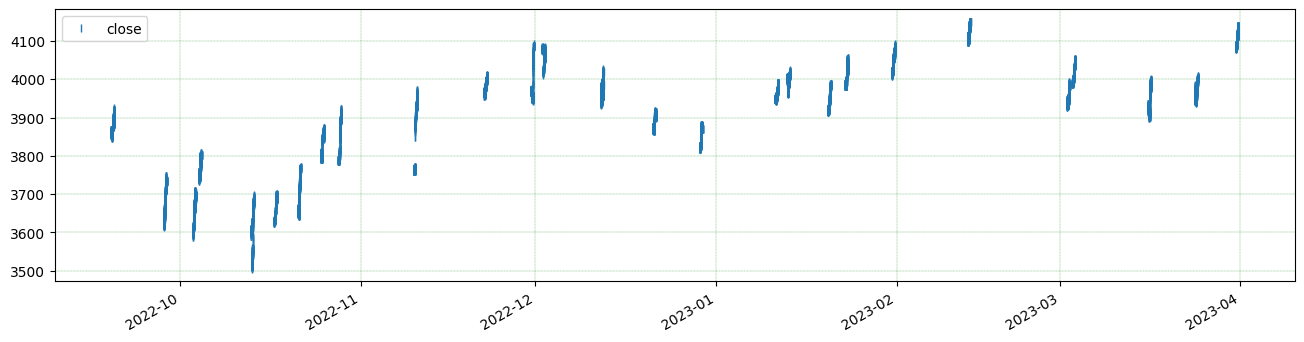

In [35]:
esUp.plot( y=['close' ], figsize=(16,4), marker='|',  linestyle='none', linewidth= 0.3)   
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

In [23]:
idx_date = esUp.index
len(idx_date)   #  10234
# esUp.index = pd.to_datetime(esUp.index) # make sure its Datetime index

# Group by day
# daily_group = esUp.groupby(esUp.index.date)

# Define the mean normalization scaling function
def mean_normalization(group):
    mean_value = group.mean()
    min_value = group.min()
    max_value = group.max()
    return (group - mean_value) / (max_value - min_value)

# Apply the mean normalization scaling function to each day's 'Close' values
es_centered = daily_group.transform(mean_normalization)

# Display the resulting centered Series
# print(es_centered)
# type(es_centered)
# es_centered = es_centered.sort_index()
# es_centered.typeU = 0.5
# es_centered.chng.interpolate(method='linear', inplace=True)
es_centered.head()  #  [10234 rows x 24 columns]


,Vol,BidAsk,open,high,low,close,type,vari,volat,taly,diff,pct_chng,fut_10,fut_5,volatility,BA_2m,BA_5m,BA_10m,BA_cs,BAr_V,vwap,vwapBA,typeD,OBV,obBA
2022-09-19 04:20:00,-0.090293,-0.015530,-0.139017,-0.154195,-0.133495,-0.143417,NaN,-0.024035,-0.156999,-0.089858,-0.967786,-0.965882,0.013105,0.013630,0.985047,-0.066801,-0.062721,-0.148854,-0.128346,0.081879,0.379623,0.186166,0.5,-0.265676,-0.402947
2022-09-19 04:22:00,-0.095894,-0.003444,-0.139017,-0.151040,-0.130216,-0.146562,NaN,-0.039660,-0.156999,-0.096323,0.001240,0.001140,0.013105,0.018564,0.983159,-0.013197,-0.073995,-0.135135,-0.128245,0.090749,0.379466,0.706119,0.5,-0.266353,-0.402961
2022-09-19 04:24:00,-0.091207,-0.004568,-0.139017,-0.135267,-0.133495,-0.118260,NaN,0.100965,-0.041614,-0.091527,0.010090,0.010598,0.002763,0.007051,-0.005190,-0.005455,-0.079632,-0.112667,-0.128548,0.091136,0.379142,0.250192,0.5,-0.264949,-0.403001
2022-09-19 04:26:00,-0.085320,0.020165,-0.113780,-0.116340,-0.113822,-0.124549,NaN,-0.055285,-0.041614,-0.087288,0.000355,0.000195,-0.001215,0.007873,-0.004215,0.011222,-0.042842,-0.056896,-0.119971,0.087612,0.378613,0.118728,0.5,-0.267266,-0.404142
2022-09-19 04:28:00,-0.092579,0.003301,-0.123244,-0.119495,-0.107265,-0.121404,NaN,0.007215,-0.099306,-0.093446,0.003010,0.003031,0.002763,-0.001173,-0.012026,0.016781,0.000771,-0.065545,-0.117448,0.095455,0.378342,0.360192,0.5,-0.266075,-0.403806


In [24]:
# del es_centered['typeD']

In [25]:
es_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'type', 'vari',
       'volat', 'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility',
       'BA_2m', 'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV',
       'obBA'],
      dtype='object')

In [10]:
es_centered.head()  #    2022-12-12 04:20:00
# es_centered.tail() 

,Vol,BidAsk,open,high,low,close,type,vwap,typeD,vari,volat,taly,vwapBA,diff,pct_chng,fut_10,fut_5,volatility,BA_2m,BA_5m,BA_10m,chng,BA_cs,BAr_V
2022-09-19 04:20:00,-0.090293,-0.015530,-0.139017,-0.154195,-0.133495,-0.143417,NaN,0.379623,0.5,-0.024035,-0.156999,-0.089858,0.186166,-0.967786,-0.965882,0.013105,0.013630,0.985047,-0.066801,-0.062721,-0.148854,-0.005106,-0.128346,0.081879
2022-09-19 04:22:00,-0.095894,-0.003444,-0.139017,-0.151040,-0.130216,-0.146562,NaN,0.379466,0.5,-0.039660,-0.156999,-0.096323,0.706119,0.001240,0.001140,0.013105,0.018564,0.983159,-0.013197,-0.073995,-0.135135,-0.139095,-0.128245,0.090749
2022-09-19 04:24:00,-0.091207,-0.004568,-0.139017,-0.135267,-0.133495,-0.118260,NaN,0.379142,0.5,0.100965,-0.041614,-0.091527,0.250192,0.010090,0.010598,0.002763,0.007051,-0.005190,-0.005455,-0.079632,-0.112667,0.027808,-0.128548,0.091136
2022-09-19 04:26:00,-0.085320,0.020165,-0.113780,-0.116340,-0.113822,-0.124549,NaN,0.378613,0.5,-0.055285,-0.041614,-0.087288,0.118728,0.000355,0.000195,-0.001215,0.007873,-0.004215,0.011222,-0.042842,-0.056896,-0.152584,-0.119971,0.087612
2022-09-19 04:28:00,-0.092579,0.003301,-0.123244,-0.119495,-0.107265,-0.121404,NaN,0.378342,0.5,0.007215,-0.099306,-0.093446,0.360192,0.003010,0.003031,0.002763,-0.001173,-0.012026,0.016781,0.000771,-0.065545,0.209701,-0.117448,0.095455


In [40]:

del  es_centered['type']
es_centered.shape

(10234, 23)

In [41]:
# (['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       # 'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       # 'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA']
es_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
      dtype='object')

In [43]:
es_centered.shape

# Save DataFrame to a pickle file
pickle_file = "ES_U.pkl"
es_centered.to_pickle(pickle_file)

# pickES = "ES_U.pkl"
# loaded_df = pd.read_pickle(pickES)
# loaded_df.head()
# (type(loaded_df.index))

#### interesting: Check  these features:  
- BA_cs  - does it have huge envelope midday in Up days?
- vwapBA - dies it have early morning above 0 to .9 heightened activity in Up days?
- BidAsk - first quarter day mostly above 0 in Up day,  
- 'BA_5m', 'BA_cs' after great spikes retreave; 'nothing runs forever' and level of -.4 to .6 are often reversal levels


In [307]:
es_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'taly',
       'taly2', 'volat', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility',
       'chng', 'BA_5m', 'BA_cs', 'vwap', 'vwapBA', 'BA_2m', 'BA_10m', 'BAr_V',
       'typeD'],
      dtype='object')

In [ ]:
es_centered['2023-03-31 04:20:00':'2023-03-31 16:20:00'].plot(y=['BA_5m', 'BA_cs'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

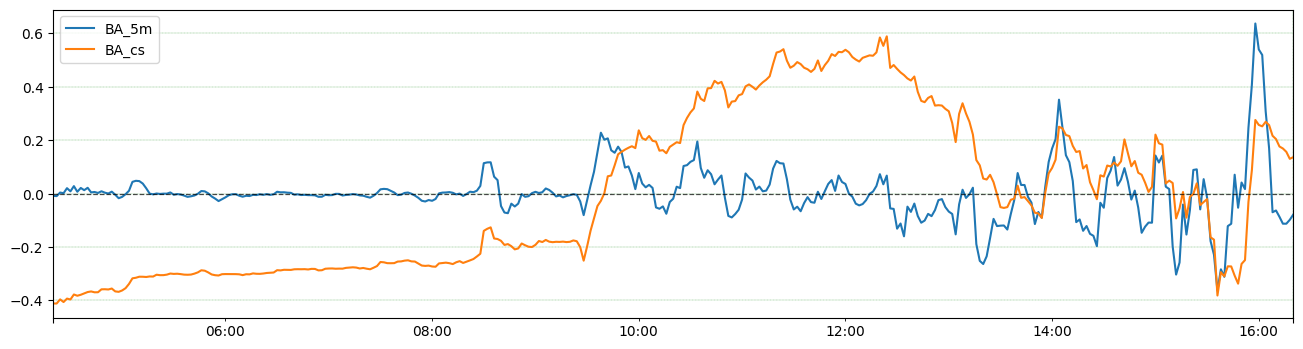

In [13]:
es_centered['2023-03-31 04:20:00':'2023-03-31 16:20:00'].plot(y=['BA_5m', 'BA_cs'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

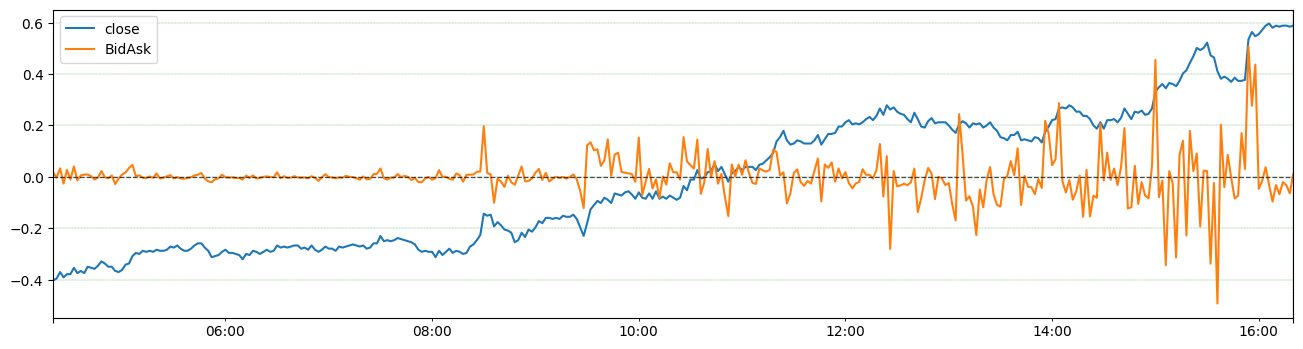

In [12]:
es_centered['2023-03-31 04:20:00':'2023-03-31 16:20:00'].plot(y=['close', 'BidAsk'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

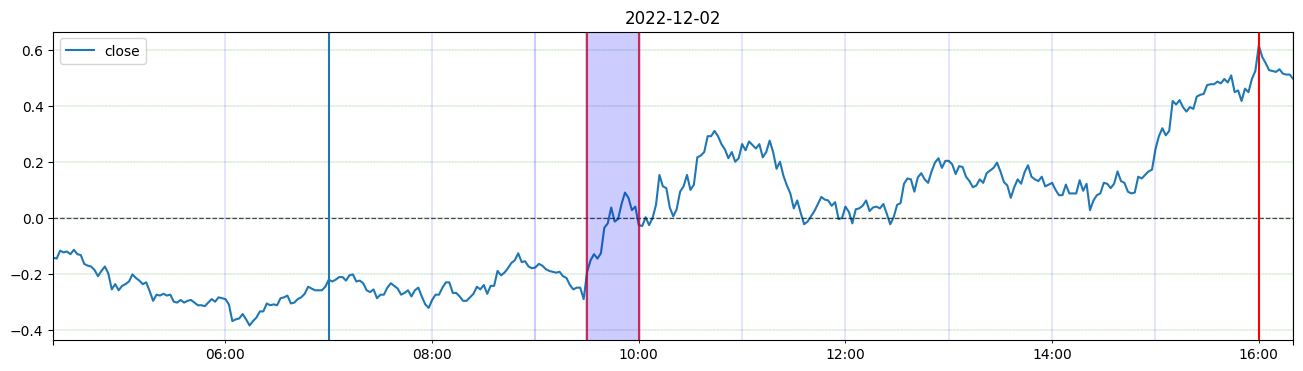

In [210]:
es_centered['2022-09-19 04:20:00':'2022-09-19 16:20:00'][['close']].plot( figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
tit = str(df.index[0])[0:10]
plt.title(tit)
plt.axvline(x=  '2022-09-19' + ' 07:00:00')
plt.axvline(x=  '2022-09-19' + ' 06:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 08:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 09:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 09:30:00', ymax = 1, linewidth= 1.5, color='red', alpha=0.8)
plt.axvline(x=  '2022-09-19' + ' 10:00:00', ymax = 1, linewidth= 1.5, color='red', alpha=0.8)
plt.axvline(x=  '2022-09-19' + ' 09:45:00', ymax = 1, linewidth= 40, color='blue', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 11:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 12:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 13:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 14:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 15:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 16:00:00', color= 'red')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

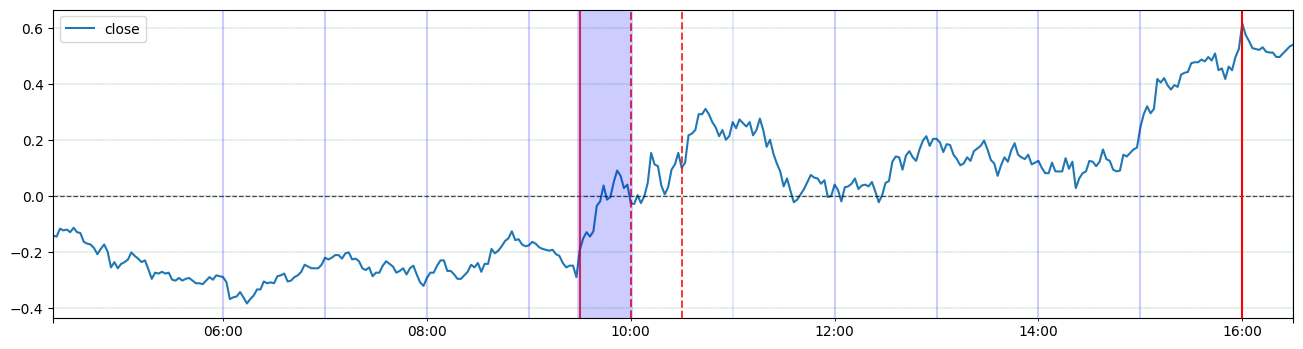

In [204]:
es_centered['2022-09-19 04:20:00': '2022-09-19 16:30:00'].plot(y='close', figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
# tit = str(df.index[0])[0:10]
# plt.title(tit)
plt.axvline(x=  '2022-09-19' + ' 07:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 06:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 08:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 09:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 09:30:00', ymax = 1, linewidth= 1.5, linestyle = '-', color='red', alpha=0.8)
plt.axvline(x=  '2022-09-19' + ' 10:00:00', ymax = 1, linewidth= 1.5, color='red', linestyle = '--', alpha=0.8)
plt.axvline(x=  '2022-09-19' + ' 9:45:00', ymax = 1, linewidth= 40, color='blue', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 10:30:00', ymax = 1, linewidth= 1.4, linestyle = '--', color='red', alpha=0.8)
plt.axvline(x=  '2022-09-19' + ' 11:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-09-19' + ' 12:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 13:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 14:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 15:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-09-19' + ' 16:00:00', color= 'red')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

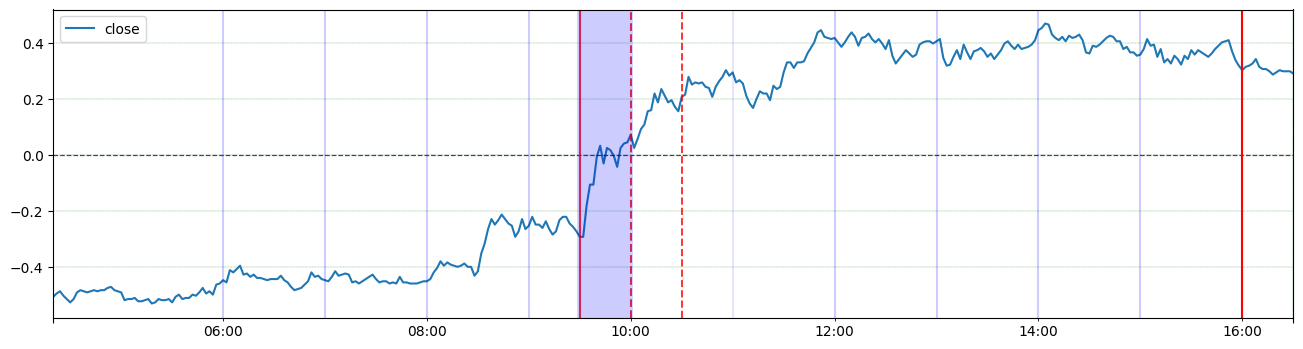

In [211]:
es_centered['2022-12-29 04:20:00':'2022-12-29 16:30:00'].plot(y='close', figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  

plt.axvline(x=  '2022-12-29' + ' 07:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 06:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 08:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 09:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 09:30:00', ymax = 1, linewidth= 1.5, linestyle = '-', color='red', alpha=0.8)
plt.axvline(x=  '2022-12-29' + ' 10:00:00', ymax = 1, linewidth= 1.5, color='red', linestyle = '--', alpha=0.8)
plt.axvline(x=  '2022-12-29' + ' 9:45:00', ymax = 1, linewidth= 40, color='blue', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 10:30:00', ymax = 1, linewidth= 1.4, linestyle = '--', color='red', alpha=0.8)
plt.axvline(x=  '2022-12-29' + ' 11:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-12-29' + ' 12:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 13:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 14:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 15:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-12-29' + ' 16:00:00', color= 'red')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

Singular values for the 9-10 hour: [1.67130867e+01 9.86352561e+00 9.25355513e+00 7.53286992e+00
 5.66538233e+00 5.50260126e+00 4.35311312e+00 4.09907176e+00
 3.25756623e+00 2.98575031e+00 2.66331630e+00 2.45529080e+00
 2.33544178e+00 2.11424508e+00 1.89634279e+00 1.60515343e+00
 1.27388131e+00 2.99186732e-01 2.43017345e-01 2.29665035e-01
 1.84459701e-01 7.54877164e-02 1.13020213e-02]
Singular values for the 10-11 hour: [1.24976994e+01 9.38904684e+00 8.29581643e+00 7.74771392e+00
 5.93917843e+00 4.59269638e+00 3.84309803e+00 3.46013141e+00
 3.30903103e+00 3.00275653e+00 2.78235342e+00 2.40697328e+00
 2.06163368e+00 1.98565361e+00 1.83059374e+00 1.61705510e+00
 1.29777100e+00 2.61675334e-01 2.50290613e-01 1.92006234e-01
 1.78924834e-01 7.44171460e-02 1.09702682e-02]


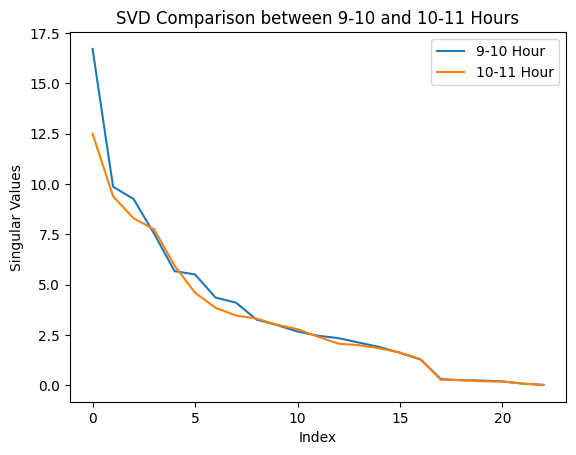

In [46]:
from scipy.linalg import svd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has columns 'Date' and 'Close'
# Make sure the 'Date' column is set as the index and is a datetime object
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = es_centered.between_time('9:00', '10:00')
df_10_to_11 = es_centered.between_time('10:00', '11:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_10_to_11, s_10_to_11, Vh_10_to_11 = svd(df_10_to_11)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_10_to_11)

# Plot the SVD values using matplotlib
plt.plot(s_9_to_10, label="9-10 Hour")
plt.plot(s_10_to_11, label="10-11 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 10-11 Hours")
plt.legend()
plt.show()


Singular values for the 9-10 hour: [1.67130867e+01 9.86352561e+00 9.25355513e+00 7.53286992e+00
 5.66538233e+00 5.50260126e+00 4.35311312e+00 4.09907176e+00
 3.25756623e+00 2.98575031e+00 2.66331630e+00 2.45529080e+00
 2.33544178e+00 2.11424508e+00 1.89634279e+00 1.60515343e+00
 1.27388131e+00 2.99186732e-01 2.43017345e-01 2.29665035e-01
 1.84459701e-01 7.54877164e-02 1.13020213e-02]
Singular values for the 10-11 hour: [3.03074212e+01 1.38537583e+01 9.74700011e+00 8.70467467e+00
 8.04760859e+00 6.35315224e+00 4.49202666e+00 4.01417817e+00
 3.27948650e+00 2.89472366e+00 2.80888402e+00 2.17846954e+00
 1.91201615e+00 1.74999989e+00 1.48700564e+00 1.42451923e+00
 6.80439329e-01 2.39297039e-01 2.23273712e-01 2.03732707e-01
 1.59920797e-01 8.91326886e-02 7.69535873e-03]


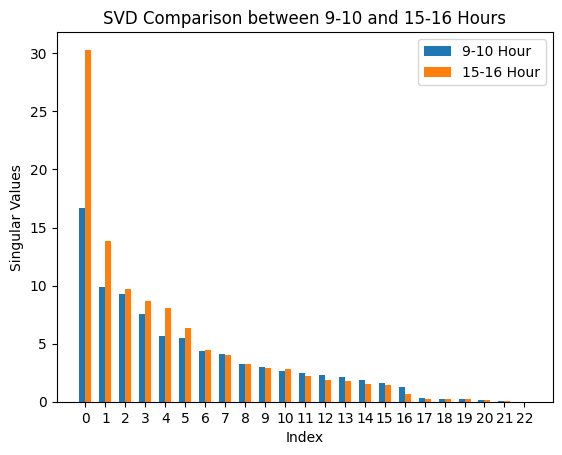

In [45]:

from scipy.linalg import svd
import matplotlib.pyplot as plt

# df['DateTime'] = pd.to_datetime(df['DateTime'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = es_centered.between_time('9:00', '10:00')
df_15_to_16 = es_centered.between_time('15:00', '16:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_15_to_16, s_15_to_16, Vh_15_to_16 = svd(df_15_to_16)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_15_to_16)

# Plot the SVD values using matplotlib
bar_width = 0.3
index = np.arange(len(s_9_to_10))

plt.bar(index, s_9_to_10, width=bar_width, label="9-10 Hour")
plt.bar(index + bar_width, s_15_to_16, width=bar_width, label="15-16 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 15-16 Hours")
plt.xticks(index + bar_width/2, index)
plt.legend()
plt.show()


Singular values for the 9-10 hour: [1.67130867e+01 9.86352561e+00 9.25355513e+00 7.53286992e+00
 5.66538233e+00 5.50260126e+00 4.35311312e+00 4.09907176e+00
 3.25756623e+00 2.98575031e+00 2.66331630e+00 2.45529080e+00
 2.33544178e+00 2.11424508e+00 1.89634279e+00 1.60515343e+00
 1.27388131e+00 2.99186732e-01 2.43017345e-01 2.29665035e-01
 1.84459701e-01 7.54877164e-02 1.13020213e-02]
Singular values for the 10-11 hour: [1.24976994e+01 9.38904684e+00 8.29581643e+00 7.74771392e+00
 5.93917843e+00 4.59269638e+00 3.84309803e+00 3.46013141e+00
 3.30903103e+00 3.00275653e+00 2.78235342e+00 2.40697328e+00
 2.06163368e+00 1.98565361e+00 1.83059374e+00 1.61705510e+00
 1.29777100e+00 2.61675334e-01 2.50290613e-01 1.92006234e-01
 1.78924834e-01 7.44171460e-02 1.09702682e-02]


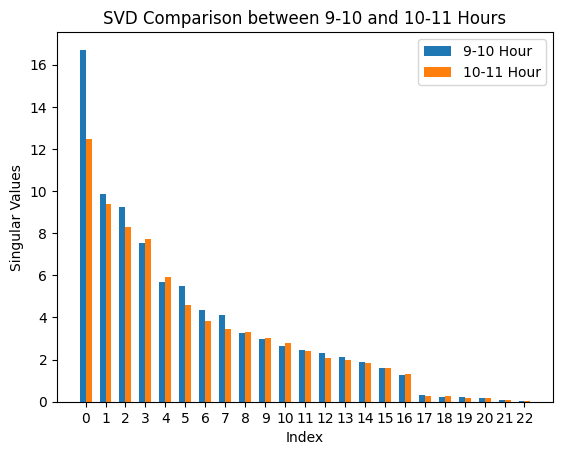

In [44]:

from scipy.linalg import svd
# import matplotlib.pyplot as plt

# df['DateTime'] = pd.to_datetime(df['DateTime'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = es_centered.between_time('9:00', '10:00')
df_10_to_11 = es_centered.between_time('10:00', '11:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_10_to_11, s_10_to_11, Vh_10_to_11 = svd(df_10_to_11)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_10_to_11)

# Plot the SVD values using matplotlib
bar_width = 0.3
index = np.arange(len(s_9_to_10))

plt.bar(index, s_9_to_10, width=bar_width, label="9-10 Hour")
plt.bar(index + bar_width, s_10_to_11, width=bar_width, label="10-11 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 10-11 Hours")
plt.xticks(index + bar_width/2, index)
plt.legend()
plt.show()
